# Import libraries

In [252]:
# The standards
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils

# Blue steel 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error

# Ridding myself of those pesky warnings
import warnings 
warnings.simplefilter("ignore")

# Read in the data

In [385]:
# Reading in cleaned up data set and dropping some columns
# During my first initial run of modeling using helper functions, I identified my train set to be 
# a shape of (247870, 216409). As a result, I am omitting these columns to help model performance. 
df = pd.read_csv('../data/clean_airbnb.csv').drop(columns=['Unnamed: 0',
                                                           'amenities', 
                                                           'property_type'
                                                          ])

In [4]:
df.shape

(354100, 35)

## Map city feature for modeling

In [5]:
df['city'] = df['city'].map({'paris': 0, 'london': 1})

----

# Modeling

## Baseline model

In [6]:
base = df._get_numeric_data()

In [7]:
# Train/Test/Split
X = base.drop(columns='price')
y = base['price']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=9
                                                   )

## Instantiating baseline model

In [9]:
dummy = DummyRegressor()

In [10]:
ss = StandardScaler()
Z_train_dummy = ss.fit_transform(X_train)
Z_test_dummy = ss.transform(X_test)

In [11]:
cross_val_score(dummy, Z_train_dummy, y_train, cv=5).mean()

-3.1239114356029776e-05

In [12]:
dummy.fit(Z_train_dummy, y_train)

DummyRegressor()

In [13]:
dummy.score(Z_train_dummy, y_train)

0.0

In [14]:
dummy.score(Z_test_dummy, y_test)

-9.556611821892602e-07

# Train-Test-Split

In [308]:
# Using the top ten most correlated features to begin with to see what preliminary score generates

X = df.drop(columns='price')
y = df['price']

In [309]:
# Good ole train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=9
                                                   )

## Addressing Features

In [310]:
numeric = [col for col in df._get_numeric_data().columns if col not in ['price']]

In [311]:
categorical = [col for col in df.columns if col not in numeric and col not in ['price']]

In [312]:
ctx = ColumnTransformer(
    [('ss', StandardScaler(), numeric),
     ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

In [313]:
# Standard Scaler to even out all our features since they are on varying units of measure
Z_train = ctx.fit_transform(X_train)
Z_test = ctx.transform(X_test)

In [314]:
# Due to a large train shape during the initial modeling run, I decided to call the shape
# after removing certain features to see if the shape narrowed significantly. 
Z_train.shape, Z_test.shape

((265575, 89), (88525, 89))

## Model Selection

In [146]:
models = {
    'linear_regression' : LinearRegression(),
    'lasso' : LassoCV(), 
    'ridge' : RidgeCV(), 
    'elastic' : ElasticNet(), 
    'tree' : DecisionTreeRegressor(),
    'regr' : RandomForestRegressor(),
    'xgb' : XGBRegressor()
}

In [147]:
## Thank you Joshua Lin for letting me use helper functions as inspiration ##
def fit_predict(model, 
                Z_train, y_train, 
                Z_test, y_test):
    
   # Return a dictionary of model performance indicators.
    
    results = {}
    
    # Fit the model on the scaled, transformed training set
    model.fit(Z_train, y_train)

    # Train & test metrics
    results['train_cross_val'] = cross_val_score(model, Z_train, y_train, cv=5).mean()
    results['train_score'] = model.score(Z_train, y_train)
    results['test_score'] = model.score(Z_test, y_test)
    
    return results

def test_models(models, 
                Z_train, y_train, 
                Z_test, y_test):
    
    # Returns DataFrame of baseline results 
    # given a dictionary `models` of 'model_name' : sklearn model().
    
    results = {}
    
    # For loop to unpack dictionary of models, 
    # fit each model, then store model's performance into DataFrame
    # ordering by test_score.
    for name, model in models.items():
        
        results[name] = fit_predict(model, 
                                     Z_train, y_train, 
                                     Z_test, y_test)
    return pd.DataFrame.from_dict(
        results, 
        orient='index').sort_values(by='test_score', ascending=False)

In [21]:
test_models(models, Z_train, y_train, Z_test, y_test)

,train_cross_val,train_score,test_score
regr,0.777921,0.971439,0.804992
xgb,0.651578,0.682195,0.654923
tree,0.571264,0.999028,0.617717
ridge,0.501256,0.501696,0.499925
linear_regression,0.501249,0.501691,0.499919
lasso,0.499651,0.500056,0.498817
elastic,0.376468,0.376546,0.374950


## Initial Model Scoring Interpretation: 
Now we have moved onto the modeling stage and have some initial looks at how seven models performed. I picked a range of models from simple like linear regression to complex like XGBoost and RandomForestRegressor. The criteria I need for a model is high performing because I would like to give clients the best information both accurately and efficiently, able to interpret feature importance because my problem statement is based around what features affect the listing price, and least overfit since there are new listings being added constantly. When a model is overfit, this means the model does poorly on unseen data and can't be trusted to make accurate interpretations on new listings. Since I will be giving hosts insights on what affects the pricing of their Air Bnb, I want to avoid giving them inaccurate information as much as possible. 

As we can see from the DataFrame above, I have used cross validation and R2 score to measure the performance of the models I've selected with their default parameters. Cross validation is important this allows us to look at the training and testing sets from, k,  different perspectives to give us more confidence in the R2 score. Since one of the criteria for my final model is least overfit, we can look to the cross validation score to give us a peak into the model's performance on unseen data. Speaking on bias/variance tradeoff for a moment, models like ridge, linear regression, lasso, and elastic performed very well in terms of having low variance however all the models have high bias based off the low scoring metrics. Although all the raw values may be close to one another, they are clustered away from the target. 

Now looking at the top three performing models based off R2 test score, the best performing model based off raw values when looking across the baseline metrics of cross validation, train, and test R2 score is RandomForestRegressor. However, XGBRegressor comes in with immense precision having little more than 0.03 between cross validation, train, and test scores. Again though, XGBRegressor's metrics fall under a similar category as the aforementioned models having low variance but high bias. Although the decision tree model is able to explain almost 100% of its variance, when looking to new data, the model becomes overfit by 38%. 

The best scoring model out of the seven models ran was the RandomForestRegressor model with a train/test of .97/.80 which is substantially better than the baseline model scoring. In addition, the XGBRegressor model did well overall with a train/test of .68/.65. Although the random forest regressor train score is nearly 100%, the model is overfit because the testing score decreases by ~18% to .65. The goal in selecting the final model is weighing the bias/variance tradeoff and trying to find the best of both worlds to minimize the total error between the two measurements. 

During some research on XGBoost and RandomForestRegressor, one of the hyperparameters for these models is assigning regularization to the model more specifically ridge regularization. Since my problem statement is based around feature importance and both models are able to evaluate the feature importance, I will tune the hyperparameters of both XGBRegressor and RandomForestRegressor.

-----

## Model Optimization

In [43]:
# Instantiate model
regr = RandomForestRegressor()

# Setting up parameters
regr_params = {
    'max_depth' : [1, 7, 13],
    'n_estimators' : [300, 400, 500],
    'random_state' : [9]
}

# Gridsearch for optimizing hyperparameters
gs_regr = GridSearchCV(regr, param_grid=regr_params, cv=5)

# Fit model
gs_regr.fit(Z_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 7, 13],
                         'n_estimators': [300, 400, 500], 'random_state': [9]})

In [41]:
# Instantiate model
xgb = XGBRegressor()

# Setting up parameters
xgb_params = {
    'max_depth' : [1, 7, 13],
    'n_estimators' : [300, 400, 500],
    'reg_alpha' : [0.0, 0.01, 0.1, 1.0],
    'random_state' : [9]
}

# Gridsearch for optimizing hyperparameters
gs_xgb = GridSearchCV(xgb, param_grid=xgb_params, cv=5)

# Fit model
gs_xgb.fit(Z_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
        

In [148]:
regr_opt = RandomForestRegressor(max_depth=13, n_estimators=500, random_state=9)
regr_opt.fit(Z_train, y_train)

RandomForestRegressor(max_depth=13, n_estimators=500, random_state=9)

In [149]:
xgb_opt = XGBRegressor(max_depth=13, n_estimators=500, random_state=9, alpha=1)
xgb_opt.fit(Z_train, y_train)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=13, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=9, reg_alpha=1, ...)

### Hyperparameters discussion: 
Since my experience around gridsearching hyper-parameters is limited, I read through the documentation and selected some hyperparameters which I could easily interpret myself. 

First, the max depth relates to how many levels or sample splits the model will perform before generating results. For XGBoost, the default is set as 6; therefore, I chose to begin at 1 split then move in iterations of the default value arriving at 1, 7, & 13. Although the RandomForestRegressor does not have a max depth and instead will run until 'all leaves are pure' according to the documentation, I wanted to use the same hyperparameters for my two top performing models to give as even a playing field as possible. 

Next, number of estimators is the number of trees or number of samples the model will aggregate with before giving a final answer. The anomaly between the two gridsearchs is the alpha hyperparameter I set in my XGBoost to make the model more conserative. Again, going back to the problem statement of feature importance, I wanted to try to incorporate regularization as much as possible in the modeling phase. 

Finally, the random state ensures the splits our model generates are can be reproduced, so Sckit-learn uses random permutations to generate the splits. 

-----

### RandomForestRegressor Results: 

In [71]:
gs_regr.best_params_

{'max_depth': 13, 'n_estimators': 500, 'random_state': 9}

### XGBRegressor Results: 

In [64]:
gs_xgb.best_params_

{'max_depth': 13, 'n_estimators': 500, 'random_state': 9, 'reg_alpha': 1.0}

----

### Bundling results into DataFrame

In [86]:
top_models = {
    'regr' : RandomForestRegressor(max_depth=13, n_estimators=500, random_state=9),
    'xgb' : XGBRegressor(max_depth=13, n_estimators=500, reg_alpha=1, random_state=9)
}

In [87]:
test_models(top_models, Z_train, y_train, Z_test, y_test)

,train_cross_val,train_score,test_score
xgb,0.800774,0.995096,0.825650
regr,0.621917,0.669913,0.625128


### XGBRegressor Scoring:
After running the gridsearch, the hyper-parameters found the highest values to be the best params for this model which made the train/test score jump up by 45% and 26% respectively. Although the raw values went up, the model has become less precise thus higher variance but lower bias. This can happen due to the max depth which indicates how many different separate times the model splits into another level of decisions. As the model continues to split, this can lead to overfitting.  

### RandomForestRegressor Scoring: 
The scoring of the models have become mirror images because the RandomForestRegressor now has become more precise but less accurate because the raw values of the train/test both decreased to nearly the same R2 score, or explained variance, as the XGBoost model before tuning the hyper-parameters through a GridSearchCV. This perhaps could be due to the max depth of the RandomForestRegressor not having a default depth. According to the documentation, 'nodes are expanded until all leaves are pure...' which I take to mean the model runs until all possible sample splits have occured.  

----

# Metrics of Top Performing Models: 

## Residuals

In [52]:
y_pred_regr = gs_regr.predict(Z_train)
y_pred_regr[:5]

array([117.33277558,  35.33984775, 126.74119381,  42.51426577,
        96.30710751])

In [88]:
residuals_regr = y_train - y_pred_regr

In [54]:
residuals_regr.mean()

0.03370866500057211

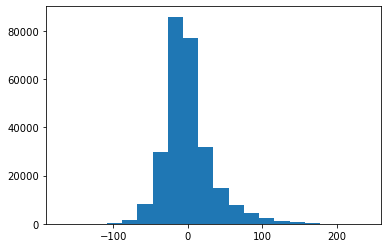

In [55]:
plt.hist(residuals_regr, bins=20);

### RandomForestRegressor Residual Histogram Interpretation: 
The RandomForestRegressor histogram has a normalish distribution but is right skewed because of the long tail to the right of x=0. 

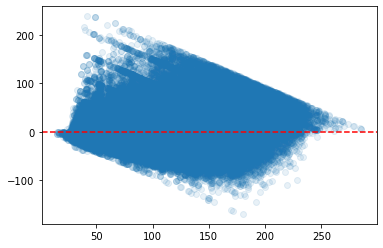

In [239]:
plt.scatter(y_pred_regr, residuals_regr, alpha=.1)
plt.axhline(0, color="red", linestyle="--");

### RandomForestRegressor Residual Scatterplot Interpretation: 
The scatterplot indicates a fanning out of the residual values from left to right and narrows sharply past x=200. Also, there are a few outliers above and below the horizontal band, but good concentration of residual values surrounding y=0. 

## Mean Absolute Error (RandomForestRegressor)

In [264]:
# Calculating and rounding the mean absolute error 
regr_mae = round(mean_absolute_error(y_train, y_pred_regr), 2)

print(f'On average the RandomForestRegressor is able to predict the price of an AirBnb listing within ${regr_mae}.')

On average the RandomForestRegressor is able to predict the price of an AirBnb listing within $22.97.


----

In [47]:
y_pred_xgb = gs_xgb.predict(Z_train)
y_pred_xgb[:5]

array([ 90.22177 ,  30.27824 , 119.657555,  35.47804 ,  97.53174 ],
      dtype=float32)

In [89]:
residuals_xgb = y_train - y_pred_xgb

In [49]:
residuals_xgb.mean()

0.0005034137779874316

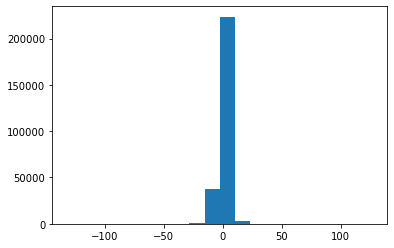

In [50]:
plt.hist(residuals_xgb, bins=20);

### XGBoost Residual Histogram: 
The histogram of XGBoost residuals are narrow and left skewed in the loosest terms because of the tail of values to the left of the mean.

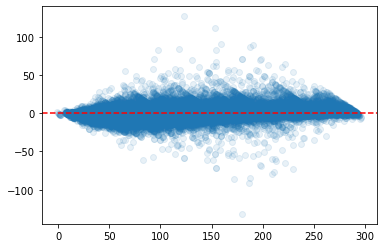

In [238]:
plt.scatter(y_pred_xgb, residuals_xgb, alpha=.1)
plt.axhline(0, color="red", linestyle="--");

### XGBoost Residual Scatterplot Interpretation: 
Although there is a heavy concentration around the horizontal band, we do see a couple outliers above and below y=0. There is an obvious diamond shape pattern which indicates the model does not perform well with the overall scope of the data.  

## Mean Absolute Error (XGBoost)

In [265]:
# Calculating and rounding the mean absolute error 
xgb_mae = round(mean_absolute_error(y_train, y_pred_xgb), 2)

print(f'On average the RandomForestRegressor is able to predict the price of an AirBnb listing within ${xgb_mae}.')

On average the RandomForestRegressor is able to predict the price of an AirBnb listing within $2.24.


-----

# Neighborhood Subset Modeling

In [240]:
# Searching for the largest neighborhood
df['neighborhood'].value_counts()[:1]

Westminster    20490
Name: neighborhood, dtype: int64

In [101]:
# Creating a subset for the Westminster neighborhood
west = df[df['neighborhood'] == 'Westminster']

# Train-Test-Split

In [280]:
# Setting my features & target variable
X = west.drop(columns='price')
y = west['price']

In [281]:
# Good ole train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=9
                                                   )

## Addressing Features

In [282]:
# Pulling numeric values out for column transformer
numeric = [col for col in west._get_numeric_data().columns if col not in ['price']]

In [283]:
# Pulling categorical values out for column transformer
categorical = [col for col in west.columns if col not in numeric and col not in ['price']]

In [284]:
ctx = ColumnTransformer(
    [('ss', StandardScaler(), numeric),
     ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

In [285]:
# Standard Scaler to even out all our features since they are on varying units of measure
Z_train_west = ctx.fit_transform(X_train)
Z_test_west = ctx.transform(X_test)

In [286]:
# Checking shapes
Z_train_west.shape, Z_test_west.shape

((15367, 37), (5123, 37))

In [287]:
test_models(models, Z_train_west, y_train, Z_test_west, y_test)

,train_cross_val,train_score,test_score
regr,0.758414,0.968451,0.772770
xgb,0.727566,0.879834,0.730841
tree,0.537302,0.999134,0.564198
linear_regression,0.448255,0.450772,0.443445
lasso,0.447598,0.450100,0.443413
ridge,0.447956,0.450466,0.442891
elastic,0.390645,0.392157,0.391312


## Top Performing Models for Westminster Model: 

In [288]:
west_models = {
    'regr_west' : RandomForestRegressor(max_depth=13, n_estimators=500, random_state=9),
    'xgb_west' : XGBRegressor(max_depth=13, n_estimators=500, reg_alpha=1, random_state=9)
}

In [289]:
test_models(west_models, Z_train_west, y_train, Z_test_west, y_test)

,train_cross_val,train_score,test_score
xgb_west,0.756420,0.999133,0.788176
regr_west,0.713028,0.869435,0.713499


In [291]:
# Instantiate model
regr_west = RandomForestRegressor(max_depth=13, n_estimators=500, random_state=9)

# Fit model
regr_west.fit(Z_train_west, y_train)

RandomForestRegressor(max_depth=13, n_estimators=500, random_state=9)

In [292]:
# Instantiate model
xgb_west = XGBRegressor(max_depth=13, n_estimators=500, reg_alpha=1, random_state=9)

# Fit model
xgb_west.fit(Z_train_west, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=13, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=9, reg_alpha=1,
             reg_lambda=1, ...)

# Plotting Metrics of Westminster Model:  

## Residuals

In [293]:
y_pred_west = regr_west.predict(Z_train_west)
y_pred_regr[:5]

array([117.33277558,  35.33984775, 126.74119381,  42.51426577,
        96.30710751])

In [294]:
residuals_west = y_train - y_pred_west

In [295]:
residuals_west.mean()

0.021524500208516328

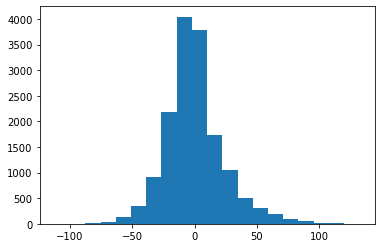

In [296]:
plt.hist(residuals_west, bins=20);

### RandomForestRegressor Residual Histogram Interpretation (Westminster): 
The RandomForestRegressor histogram for the neighborhood of Westminster subset has a normal distribution which should give us a bit more confidence in the previous discussion about categorical features distorting some of the residuals. 

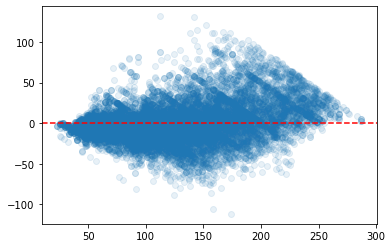

In [297]:
plt.scatter(y_pred_west, residuals_west, alpha=.1)
plt.axhline(0, color="red", linestyle="--");

### RandomForestRegressor Residual Scatterplot Interpretation (Westminster): 
Although there is a small improvement on the residual scatterplot values becoming more random, I can still make out a slight diamond pattern which means for the final insights given I will include a disclaimer on the percentage of risk involved in taking full confidence with the feature importance. 

## Mean Absolute Error

In [298]:
# Calculating and rounding the mean absolute error 
regr_mae_west = round(mean_absolute_error(y_train, y_pred_west), 2)

print(f'On average the RandomForestRegressor is able to predict the price of an AirBnb listing in the Westminster neighborhood within ${regr_mae_west}.')

On average the RandomForestRegressor is able to predict the price of an AirBnb listing in the Westminster neighborhood within $17.0.


----

In [299]:
y_pred_west_xgb = xgb_west.predict(Z_train)
y_pred_west_xgb[:5]

array([150.02617, 170.9504 , 266.9889 , 148.99197, 200.00594],
      dtype=float32)

In [300]:
residuals_west_xgb = y_train - y_pred_west_xgb

In [301]:
residuals_west_xgb.mean()

-8.444489115207811e-07

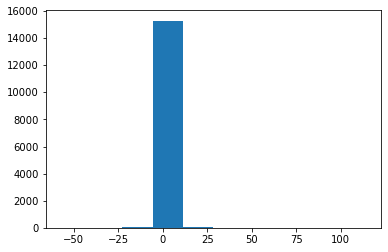

In [302]:
plt.hist(residuals_west_xgb, bins=10);

### XGBoost Residual Histogram (Westminster): 
The hisogram has nearly only one narrow bar centered over the mean; therefore, the distribution is neither normally distributed or skewed. 

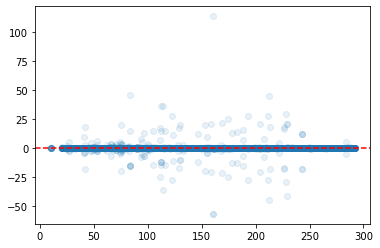

In [303]:
plt.scatter(y_pred_west_xgb, residuals_west_xgb, alpha=.1)
plt.axhline(0, color="red", linestyle="--");

### XGBoost Residual Scatterplot Interpretation (Westminster): 
The concentration of residual values is tightly hugging the y=0 line meaning the predicted v. true values is low. 

## Mean Absolute Error

In [306]:
# Calculating and rounding the mean absolute error 
xgb_mae_west = round(mean_absolute_error(y_train, y_pred_west_xgb), 2)

print(f'On average the XGBRegressor is able to predict the price of an AirBnb listing in the Westminster neighborhood within ${xgb_mae_west}.')

On average the XGBRegressor is able to predict the price of an AirBnb listing in the Westminster neighborhood within $0.16.


----

## Feature Importance/Recommendations: 

In [351]:
# Creating a DataFrame for feature importances
xgb_feature_importance = pd.DataFrame(
    
    # Pulling feature importances from XGB model
    data=xgb_opt.feature_importances_, 
    
    # Setting index as the column transformer feature names
    index=ctx.get_feature_names_out(), 
    
    # Sorting features by their importance to the target variable, price
    columns=['feature_importance']).sort_values(
        by=['feature_importance'], 
        ascending=False)

In [353]:
xgb_feature_importance.index = xgb_feature_importance.index.str.lower().str.replace('ohe', ' ').str.replace('ss', ' ').str.replace('__', ' ').str.replace('_', ' ')

In [360]:
xgb_feature_importance.head(15)

,feature_importance
room type private room,0.778062
room type hotel room,0.027723
room type shared room,0.021143
accommodates,0.011822
calculated host listings count shared rooms,0.010518
neighborhood westminster,0.007046
neighborhood kensington and chelsea,0.006991
baths,0.006382
neighborhood city of london,0.006371
neighborhood croydon,0.005017


In [355]:
# Creating a DataFrame for feature importances
regr_feature_importance = pd.DataFrame(
    
    # Pulling feature importances from RandomForestRegressor model
    data=regr_opt.feature_importances_, 
    
    # Setting index as the column transformer feature names
    index=ctx.get_feature_names_out(), 
    
    # Sorting features by their importance to the target variable, price
    columns=['feature_importance']).sort_values(
        by=['feature_importance'], 
        ascending=False)

In [356]:
regr_feature_importance.index = regr_feature_importance.index.str.lower().str.replace('ohe', ' ').str.replace('ss', ' ').str.replace('__', ' ').str.replace('_', ' ')

In [358]:
regr_feature_importance.head(15)

,feature_importance
room type private room,0.318531
accommodates,0.157314
availability 365,0.092876
latitude,0.080296
longitude,0.052297
calculated host listings count,0.040882
baths,0.035855
availability 30,0.031471
host id,0.020934
review scores location,0.018161


## Calculations for insights

In [381]:
private_room = df[df['room_type'] == 'Private room']
price_pr = round(private_room['price'].mean(), 2)
print(f'A host who has a private room and lists on AirBnb can charge around ${price_pr} per night.')

A host who has a private room and lists on AirBnb can charge around $57.43.


In [383]:
accommodates_two = df[df['accommodates'] == 2]
price_two = round(accommodates_two['price'].mean(), 2)
print(f'A host who has accommodations for two guests can charge around ${price_two} per night.')

A host who has accommodations for two guests can charge around $79.68 per night.


In [384]:
west_private = west[west['room_type'] == 'Private room']
west_price = round(west_private['price'].mean(), 2)
print(f'A host who has a private room in the neighborhood of Westminster can charge around ${west_price} per night.')

A host who has a private room in the neighborhood of Westminster can charge around $82.68 per night.


## Feature Importance Interpretation
With varying levels of weight, the models both equate private room as being one of the most important features affecting price. Then XGBRegressor lists hotel room, shared room, and how many people the unit accommodates as the next three most important features affecting the listing price. While RandomForestRegressor lists accommodates, availability of the unit within a year's time, and the latitude/longitude of the unit as the most important features affecting price. Although I chose XGBRegressor as my final model based off the metrics, I find the feature importance of RandomForestRegressor to be a much more intuitive bundle of results, but I digress. 

Based off these two perspectives, my final insights to answer my problem statement are suggesting if available - renting out a spare room may be the best piece of advice I could give to someone looking to break into the AirBnb market because hosts can charge around ~58 USD per night. Furthermore, if a host has accommodations for two guests, they can charge around ~80 USD per night. 

In addition to these features, the London neighborhoods appear higher in the feature importance lists so I can only imagine having a listing in neighborhoods like Westminster and Kensington & Chelsea drive the price as well. The features, in a loose sense of the term, have a macro focus - location of listing, room type, and how many people the unit accommodates are the important features affecting price. The best a host could hope for would be a private room in Westminster because one is able to charge nearly 44% more per night. 

## Final Thoughts: 

Overall, the models performed quite well given the size of the data and the fact two completely different internationally renowned destinations were incorporated. When running initial modeling tests to ensure I would be able to use this dataset, a basic linear regression model was scoring at .21 R2 score on just the numeric data with all nulls dropped. I have to say I am proud of my thorough approach and appreciative of my instructors for guiding me through this process. The greatest helper to the modeling phase was in my cleaning notebook were I used the IQR to address outliers which caused the correlation of my top features to double. In addition, my due diligence on the reason behind dropping 10% of null values in price which turned out to be rental units in Paris was a win as well.

My goal in selecting a final model between the two top performing models was to ensure the model was able to pass all LINE assumptions. The LINE assumptions are L-Linearity, I-Independent, N-Normal, E-Equal Variance. From the residual scatter plots of our two models, we see a clear violation of the last LINE assumption which is equal variance. In order for our models to pass all this assumption, there must be no pattern and the residual, or error term is constant - homoscedasticity. 

Even if the other LINE assumptions are being followed such as the residual plots being normally distributed, each event occuring independent of the other, and our target variable, price, having a linear relationship with the x-variables, or features. Again, as I have said before, my problem statement is based around how features affect price and will need to pull out feature importances to interpret their relationship to price. With this being said, our insights and interpretations should be given with a word of caution since one of the LINE assumptions has been violated. 

During some discussion with my instructors, we arrived at the potential reason for this diamond pattern may be due to categorical features. Luckily, my dataset contains only a couple categorical features, neighborhood & room_type. The next step I will take in diving deeper into why this violation occured is by taking a subset of the largest neighborhood out of the two cities I am analyzing. I will then repeat the exact same modeling steps, scoring, and plotting to see if zooming in on a specific neighborhood will allow me to gain better insights.  

Since I have run the subset modeling phase and again find myself in nearly the same boat, I will proceed with giving insights to help solve my problem statement, but I will be giving them with a fair announcement of caution. The scoring and plots followed a similar pattern; however, there was an improvement with the scatter plots becoming a bit more equally varied. 

An update I received during some more discussion was surrounding the LINE assumptions only being applicable to linear models and not useful in tree based models which are the two top performing models I have chosen to pull feature importances out and optimize. This is reassuring because I was unsure how to proceed after examining my data on neighborhood level for the residuals to generate a similar pattern. I was given some guidance on using another metric to give my audience easily explainable insight through the MAE - mean absolute error. As a result, I will also be using the MAE for help in chosing a final model. 

When looking at the mean absolute error, XGBRegressor, MAE of 2.24 USD, does around 100x better at predicting the price of listings compared to RandomForestRegressor, MAE of 22.97 USD. Furthermore, when I zoom the lens in closer to a neighborhood level, the XGBRegressor can predict pricing within 0.16 cents and RandomForestRegressor can predict pricing within 17 USD. Even though my final decision was XGBRegressor as my top performing model , I was interested in seeing the two different perspectives of feature importances from my two top performing models to give more robust insights to AirBnb hosts on what drives the price most.